In [ ]:
# ============================================================
# sports1_clean.ipynb (Colab-ready, "Run all" notebook)
# Project: Pass-Catcher Continuity vs YoY Offensive Efficiency
# NOTE: This uses SIMULATED (synthetic) data to prototype the framework.
# ============================================================

# ----------------------------
# CELL 1 — Imports + settings
# ----------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)

# Use /content for Colab (clean + predictable)
PLAYER_CSV_PATH = "/content/player_targets.csv"
TEAM_CSV_PATH = "/content/team_offense.csv"


# ----------------------------------------
# CELL 2 — Generate synthetic NFL-like data
# ----------------------------------------
teams = [
    "ARI","ATL","BAL","BUF","CAR","CHI","CIN","CLE","DAL","DEN","DET","GB","HOU","IND","JAX","KC",
    "LA","LAC","LV","MIA","MIN","NE","NO","NYG","NYJ","PHI","PIT","SEA","SF","TB","TEN","WAS"
]
seasons = [2022, 2023, 2024]

first_names = [
    "Aiden","Jordan","Miles","Darius","Chris","Devin","Tyler","Zach","Jalen","Marcus","Cameron","Noah",
    "Evan","Bryce","Trevor","Isaiah","Khalil","Andre","Nate","Cole","Rashad","Dion","Malik","Trey"
]
last_names = [
    "Johnson","Williams","Brown","Davis","Miller","Wilson","Moore","Taylor","Anderson","Thomas","Jackson",
    "White","Harris","Martin","Thompson","Garcia","Martinez","Robinson","Clark","Lewis","Walker","Hall",
    "Young","Allen"
]

def make_player_name() -> str:
    return f"{rng.choice(first_names)} {rng.choice(last_names)}"

# Latent team offensive baseline (small spread)
team_strength = {t: float(rng.normal(0.0, 0.08)) for t in teams}

player_rows = []
team_rows = []

for team in teams:
    prev_players = None     # list of tuples: (player_id, player_name, position)
    prev_shares = None      # numpy array of target shares (sum to 1)
    base_epa = team_strength[team]

    for season in seasons:
        total_targets = int(np.clip(rng.normal(575, 55), 450, 720))

        if prev_players is None:
            # First season for each team: just create a pass-catcher room
            continuity = float(np.clip(rng.beta(4, 2), 0.35, 0.92))
            n_receivers = int(rng.integers(6, 10))  # 6–9
            positions = (["WR"] * int(rng.integers(4, 7))) + (["TE"] * int(rng.integers(1, 3)))
            while len(positions) < n_receivers:
                positions.append(rng.choice(["WR","TE"]))
            rng.shuffle(positions)

            players = []
            for i in range(n_receivers):
                pid = f"{team}-{season}-{i}-{int(rng.integers(1000, 9999))}"
                players.append((pid, make_player_name(), positions[i]))

            alpha = rng.uniform(0.8, 2.2, size=n_receivers)
            shares = rng.dirichlet(alpha)

        else:
            # Subsequent seasons: carry some usage forward, add churn
            continuity = float(np.clip(rng.beta(5, 2), 0.25, 0.93))

            n_prev = len(prev_players)
            n_return = int(np.clip(rng.integers(max(3, n_prev - 3), n_prev + 1), 3, n_prev))
            return_idx = rng.choice(np.arange(n_prev), size=n_return, replace=False)

            returning_players = [prev_players[i] for i in return_idx]
            returning_prev = prev_shares[return_idx]
            returning_prev = returning_prev / returning_prev.sum()

            # Small usage churn among returners
            churn = rng.normal(0, 0.06, size=n_return)
            ret_shares = np.clip(returning_prev + churn, 0.001, None)
            ret_shares = (ret_shares / ret_shares.sum()) * continuity

            # New players fill remaining share
            remaining_share = 1.0 - continuity
            n_new = int(rng.integers(1, 4))  # 1–3 new
            new_players = []
            for j in range(n_new):
                pid = f"{team}-{season}-N{j}-{int(rng.integers(1000, 9999))}"
                pos = rng.choice(["WR","TE"], p=[0.75, 0.25])
                new_players.append((pid, make_player_name(), pos))

            new_alpha = rng.uniform(0.8, 2.0, size=n_new)
            new_shares = rng.dirichlet(new_alpha) * remaining_share

            players = returning_players + new_players
            shares = np.concatenate([ret_shares, new_shares])

            # Shuffle so "returners" aren't always listed first
            order = rng.permutation(len(players))
            players = [players[i] for i in order]
            shares = shares[order]

        # Optional RB target bucket (screen game / checkdown usage)
        if rng.random() < 0.45:
            rb_share = float(np.clip(rng.normal(0.09, 0.03), 0.03, 0.16))
            rb_id = f"{team}-{season}-RB-{int(rng.integers(1000, 9999))}"
            players.append((rb_id, make_player_name(), "RB"))
            shares = shares * (1 - rb_share)
            shares = np.append(shares, rb_share)

        # Convert shares to integer targets and preserve total_targets exactly
        targets = np.floor(shares * total_targets).astype(int)
        remainder = total_targets - targets.sum()
        if remainder > 0:
            add_idx = rng.choice(np.arange(len(targets)), size=remainder, replace=True)
            for i in add_idx:
                targets[i] += 1

        # Store player-level rows
        for (pid, pname, pos), t in zip(players, targets):
            player_rows.append({
                "season": season,
                "team": team,
                "player_id": pid,
                "player": pname,
                "position": pos,
                "targets": int(t),
            })

        # Team offense EPA/play: baseline + small continuity effect + noise
        epa = base_epa + 0.10 * (continuity - 0.55) + float(rng.normal(0, 0.045))
        team_rows.append({
            "season": season,
            "team": team,
            "offensive_epa_per_play": float(epa),
        })

        # Update for next season
        prev_players = players
        prev_shares = shares

player_targets = pd.DataFrame(player_rows)
team_offense = pd.DataFrame(team_rows)

# Add target_share column (useful + clean)
team_target_totals = (
    player_targets.groupby(["season", "team"], as_index=False)["targets"]
    .sum()
    .rename(columns={"targets": "team_targets"})
)
player_targets = player_targets.merge(team_target_totals, on=["season", "team"])
player_targets["target_share"] = player_targets["targets"] / player_targets["team_targets"]
player_targets = player_targets.drop(columns=["team_targets"])


# -------------------------------
# CELL 3 — Save CSVs (Colab /content)
# -------------------------------
player_targets.to_csv(PLAYER_CSV_PATH, index=False)
team_offense.to_csv(TEAM_CSV_PATH, index=False)

print("Saved:", PLAYER_CSV_PATH)
print("Saved:", TEAM_CSV_PATH)

display(player_targets.head(8))
display(team_offense.head(8))


# -------------------------------------------------------
# CELL 4 — Compute pass-catcher continuity (targets-based)
# Definition:
#   In season N, continuity = sum of target_share for players who were
#   on the same team in season N-1
# -------------------------------------------------------
players = player_targets.copy()

prev_players = players[["season", "team", "player_id"]].copy()
prev_players["season"] += 1  # aligns prior-year roster with current year

returning = players.merge(prev_players, on=["season", "team", "player_id"], how="inner")

continuity = (
    returning.groupby(["season", "team"], as_index=False)
    .agg(pass_catcher_continuity=("target_share", "sum"))
)

display(continuity.head(8))


# -------------------------------------------
# CELL 5 — Compute YoY change in offensive EPA
# -------------------------------------------
team = team_offense.copy()

prev_epa = team[["season", "team", "offensive_epa_per_play"]].copy()
prev_epa["season"] += 1
prev_epa = prev_epa.rename(columns={"offensive_epa_per_play": "epa_prev"})

epa = team.merge(prev_epa, on=["season", "team"], how="inner")
epa["epa_change"] = epa["offensive_epa_per_play"] - epa["epa_prev"]

display(epa.head(8))


# -----------------------------------------
# CELL 6 — Final dataset + sanity checks
# -----------------------------------------
final = continuity.merge(epa[["season", "team", "epa_change"]], on=["season", "team"], how="inner").dropna()

print("Rows in final:", len(final))
print(final.describe())

display(final.head(10))


# ------------------------------
# CELL 7 — Plot (deliverable)
# ------------------------------
plt.figure(figsize=(8, 6))
plt.scatter(final["pass_catcher_continuity"], final["epa_change"])

plt.axhline(0, linestyle="--", linewidth=1)
plt.xlabel("Pass Catcher Continuity (% of targets to returning players)")
plt.ylabel("Change in Offensive EPA/play (YoY)")
plt.title("Prototype: Pass Catcher Continuity vs YoY Offensive Efficiency (Simulated Data)")

plt.tight_layout()
plt.show()


# -----------------------------------
# CELL 8 — Top/Bottom examples table
# -----------------------------------
top5 = final.sort_values("pass_catcher_continuity", ascending=False).head(5)
bot5 = final.sort_values("pass_catcher_continuity", ascending=True).head(5)

print("\nHighest continuity teams:")
display(top5)

print("\nLowest continuity teams:")
display(bot5)


# -----------------------------------
# CELL 9 — Export final table (optional)
# -----------------------------------
FINAL_TABLE_PATH = "/content/continuity_vs_epa_change.csv"
final.to_csv(FINAL_TABLE_PATH, index=False)
print("Saved final table:", FINAL_TABLE_PATH)


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)

PLAYER_CSV_PATH = "/content/player_targets.csv"
TEAM_CSV_PATH = "/content/team_offense.csv"

In [27]:
teams = [
    "ARI","ATL","BAL","BUF","CAR","CHI","CIN","CLE","DAL","DEN","DET","GB","HOU","IND","JAX","KC",
    "LA","LAC","LV","MIA","MIN","NE","NO","NYG","NYJ","PHI","PIT","SEA","SF","TB","TEN","WAS"
]
seasons = [2022, 2023, 2024]

first_names = [
    "Aiden","Jordan","Miles","Darius","Chris","Devin","Tyler","Zach","Jalen","Marcus","Cameron","Noah",
    "Evan","Bryce","Trevor","Isaiah","Khalil","Andre","Nate","Cole","Rashad","Dion","Malik","Trey"
]
last_names = [
    "Johnson","Williams","Brown","Davis","Miller","Wilson","Moore","Taylor","Anderson","Thomas","Jackson",
    "White","Harris","Martin","Thompson","Garcia","Martinez","Robinson","Clark","Lewis","Walker","Hall",
    "Young","Allen"
]

def make_player_name() -> str:
    return f"{rng.choice(first_names)} {rng.choice(last_names)}"

team_strength = {t: float(rng.normal(0.0, 0.08)) for t in teams}

player_rows = []
team_rows = []

for team in teams:
    prev_players = None
    prev_shares = None
    base_epa = team_strength[team]

    for season in seasons:
        total_targets = int(np.clip(rng.normal(575, 55), 450, 720))

        if prev_players is None:
            continuity = float(np.clip(rng.beta(4, 2), 0.35, 0.92))
            n_receivers = int(rng.integers(6, 10))
            positions = (["WR"] * int(rng.integers(4, 7))) + (["TE"] * int(rng.integers(1, 3)))
            while len(positions) < n_receivers:
                positions.append(rng.choice(["WR","TE"]))
            rng.shuffle(positions)

            players = []
            for i in range(n_receivers):
                pid = f"{team}-{season}-{i}-{int(rng.integers(1000, 9999))}"
                players.append((pid, make_player_name(), positions[i]))

            alpha = rng.uniform(0.8, 2.2, size=n_receivers)
            shares = rng.dirichlet(alpha)

        else:
            continuity = float(np.clip(rng.beta(5, 2), 0.25, 0.93))

            n_prev = len(prev_players)
            n_return = int(np.clip(rng.integers(max(3, n_prev - 3), n_prev + 1), 3, n_prev))
            return_idx = rng.choice(np.arange(n_prev), size=n_return, replace=False)

            returning_players = [prev_players[i] for i in return_idx]
            returning_prev = prev_shares[return_idx]
            returning_prev = returning_prev / returning_prev.sum()

            churn = rng.normal(0, 0.06, size=n_return)
            ret_shares = np.clip(returning_prev + churn, 0.001, None)
            ret_shares = (ret_shares / ret_shares.sum()) * continuity

            remaining_share = 1.0 - continuity
            n_new = int(rng.integers(1, 4))
            new_players = []
            for j in range(n_new):
                pid = f"{team}-{season}-N{j}-{int(rng.integers(1000, 9999))}"
                pos = rng.choice(["WR","TE"], p=[0.75, 0.25])
                new_players.append((pid, make_player_name(), pos))

            new_alpha = rng.uniform(0.8, 2.0, size=n_new)
            new_shares = rng.dirichlet(new_alpha) * remaining_share

            players = returning_players + new_players
            shares = np.concatenate([ret_shares, new_shares])

            order = rng.permutation(len(players))
            players = [players[i] for i in order]
            shares = shares[order]

        if rng.random() < 0.45:
            rb_share = float(np.clip(rng.normal(0.09, 0.03), 0.03, 0.16))
            rb_id = f"{team}-{season}-RB-{int(rng.integers(1000, 9999))}"
            players.append((rb_id, make_player_name(), "RB"))
            shares = shares * (1 - rb_share)
            shares = np.append(shares, rb_share)

        targets = np.floor(shares * total_targets).astype(int)
        remainder = total_targets - targets.sum()
        if remainder > 0:
            add_idx = rng.choice(np.arange(len(targets)), size=remainder, replace=True)
            for i in add_idx:
                targets[i] += 1

        for (pid, pname, pos), t in zip(players, targets):
            player_rows.append({
                "season": season,
                "team": team,
                "player_id": pid,
                "player": pname,
                "position": pos,
                "targets": int(t),
            })

        epa = base_epa + 0.10 * (continuity - 0.55) + float(rng.normal(0, 0.045))
        team_rows.append({
            "season": season,
            "team": team,
            "offensive_epa_per_play": float(epa),
        })

        prev_players = players
        prev_shares = shares

player_targets = pd.DataFrame(player_rows)
team_offense = pd.DataFrame(team_rows)

team_target_totals = (
    player_targets.groupby(["season", "team"], as_index=False)["targets"]
    .sum()
    .rename(columns={"targets": "team_targets"})
)
player_targets = player_targets.merge(team_target_totals, on=["season", "team"])
player_targets["target_share"] = player_targets["targets"] / player_targets["team_targets"]
player_targets = player_targets.drop(columns=["team_targets"])

In [28]:
player_targets.to_csv(PLAYER_CSV_PATH, index=False)
team_offense.to_csv(TEAM_CSV_PATH, index=False)

print("Saved:", PLAYER_CSV_PATH)
print("Saved:", TEAM_CSV_PATH)

display(player_targets.head(8))
display(team_offense.head(8))

Saved: /content/player_targets.csv
Saved: /content/team_offense.csv


,season,team,player_id,player,position,targets,target_share
0,2022,ARI,ARI-2022-0-1231,Evan Hall,WR,95,0.179245
1,2022,ARI,ARI-2022-1-8181,Devin Moore,WR,70,0.132075
2,2022,ARI,ARI-2022-2-8050,Cole Moore,WR,0,0.000000
3,2022,ARI,ARI-2022-3-1027,Cameron Thompson,WR,86,0.162264
4,2022,ARI,ARI-2022-4-4993,Malik Lewis,WR,27,0.050943
5,2022,ARI,ARI-2022-5-8089,Aiden Walker,TE,33,0.062264
6,2022,ARI,ARI-2022-6-7796,Marcus Thompson,WR,73,0.137736
7,2022,ARI,ARI-2022-7-8417,Dion Martin,WR,88,0.166038


,season,team,offensive_epa_per_play
0,2022,ARI,0.022761
1,2023,ARI,-0.030182
2,2024,ARI,0.007559
3,2022,ATL,-0.020065
4,2023,ATL,0.085384
5,2024,ATL,0.052390
6,2022,BAL,0.124305
7,2023,BAL,0.091941


In [29]:
players = player_targets.copy()

prev_players = players[["season", "team", "player_id"]].copy()
prev_players["season"] += 1  # aligns prior-year roster with current year

returning = players.merge(prev_players, on=["season", "team", "player_id"], how="inner")

continuity = (
    returning.groupby(["season", "team"], as_index=False)
    .agg(pass_catcher_continuity=("target_share", "sum"))
)

display(continuity.head(8))

,season,team,pass_catcher_continuity
0,2023,ARI,0.480243
1,2023,ATL,0.827723
2,2023,BAL,0.812601
3,2023,BUF,0.910092
4,2023,CAR,0.473373
5,2023,CHI,0.749169
6,2023,CIN,0.637500
7,2023,CLE,0.790447


In [30]:
team = team_offense.copy()

prev_epa = team[["season", "team", "offensive_epa_per_play"]].copy()
prev_epa["season"] += 1
prev_epa = prev_epa.rename(columns={"offensive_epa_per_play": "epa_prev"})

epa = team.merge(prev_epa, on=["season", "team"], how="inner")
epa["epa_change"] = epa["offensive_epa_per_play"] - epa["epa_prev"]

display(epa.head(8))

,season,team,offensive_epa_per_play,epa_prev,epa_change
0,2023,ARI,-0.030182,0.022761,-0.052943
1,2024,ARI,0.007559,-0.030182,0.037741
2,2023,ATL,0.085384,-0.020065,0.105449
3,2024,ATL,0.052390,0.085384,-0.032994
4,2023,BAL,0.091941,0.124305,-0.032364
5,2024,BAL,0.095664,0.091941,0.003723
6,2023,BUF,0.045448,0.086131,-0.040683
7,2024,BUF,0.133469,0.045448,0.088021


In [31]:
final = continuity.merge(epa[["season", "team", "epa_change"]], on=["season", "team"], how="inner").dropna()

print("Rows in final:", len(final))
print(final.describe())

display(final.head(10))

Rows in final: 64
            season  pass_catcher_continuity  epa_change
count    64.000000                64.000000   64.000000
mean   2023.500000                 0.689107    0.000548
std       0.503953                 0.153427    0.066868
min    2023.000000                 0.288344   -0.158499
25%    2023.000000                 0.582472   -0.039814
50%    2023.500000                 0.709225    0.000076
75%    2024.000000                 0.805928    0.046036
max    2024.000000                 0.927711    0.145527


,season,team,pass_catcher_continuity,epa_change
0,2023,ARI,0.480243,-0.052943
1,2023,ATL,0.827723,0.105449
2,2023,BAL,0.812601,-0.032364
3,2023,BUF,0.910092,-0.040683
4,2023,CAR,0.473373,-0.075500
5,2023,CHI,0.749169,-0.051233
6,2023,CIN,0.637500,0.051482
7,2023,CLE,0.790447,0.028020
8,2023,DAL,0.748120,0.091750
9,2023,DEN,0.845313,0.055920


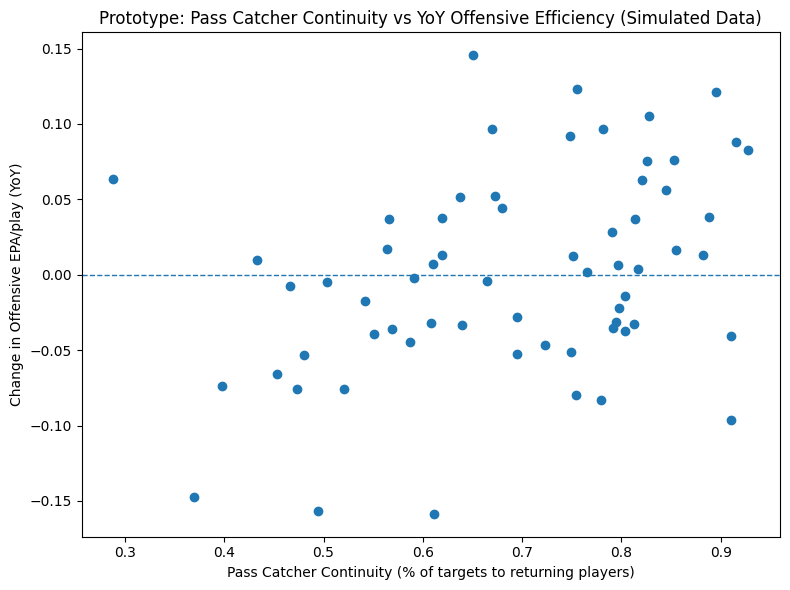

In [32]:
plt.figure(figsize=(8, 6))
plt.scatter(final["pass_catcher_continuity"], final["epa_change"])

plt.axhline(0, linestyle="--", linewidth=1)
plt.xlabel("Pass Catcher Continuity (% of targets to returning players)")
plt.ylabel("Change in Offensive EPA/play (YoY)")
plt.title("Prototype: Pass Catcher Continuity vs YoY Offensive Efficiency (Simulated Data)")

plt.tight_layout()
plt.show()

In [33]:
top5 = final.sort_values("pass_catcher_continuity", ascending=False).head(5)
bot5 = final.sort_values("pass_catcher_continuity", ascending=True).head(5)

print("\nHighest continuity teams:")
display(top5)

print("\nLowest continuity teams:")
display(bot5)


Highest continuity teams:


,season,team,pass_catcher_continuity,epa_change
18,2023,LV,0.927711,0.082848
35,2024,BUF,0.915225,0.088021
3,2023,BUF,0.910092,-0.040683
45,2024,IND,0.909864,-0.096046
10,2023,DET,0.895105,0.121164



Lowest continuity teams:


,season,team,pass_catcher_continuity,epa_change
36,2024,CAR,0.288344,0.063305
58,2024,PIT,0.369231,-0.147413
27,2023,SEA,0.397651,-0.073868
17,2023,LAC,0.432675,0.009976
24,2023,NYJ,0.452922,-0.065709


In [34]:
FINAL_TABLE_PATH = "/content/continuity_vs_epa_change.csv"
final.to_csv(FINAL_TABLE_PATH, index=False)
print("Saved final table:", FINAL_TABLE_PATH)

Saved final table: /content/continuity_vs_epa_change.csv
